In [17]:
import numpy as np
import scipy

In [18]:
mat = scipy.io.loadmat('datasets/irmdata/alyawarradata.mat')
d = mat['Rs']
d.shape

(104, 104, 26)

In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import sys
sys.path.append("/Users/aleix11alcacer/Projects/archetypes")

In [21]:
from archetypes.algorithms.torch import NAA
from models import BiAA, DBiAA
import torch

In [22]:
data = torch.tensor(d).float().reshape(d.shape)

n_arch = 16
model = NAA((n_arch, n_arch), d.shape, relations=[0, 0], degree_correction=False, membership="soft", device="cpu", 
            loss="bernoulli")
model.fit(data, n_epochs=1_000, learning_rate=0.05)

  0%|          | 0/1000 [00:00<?, ?it/s]

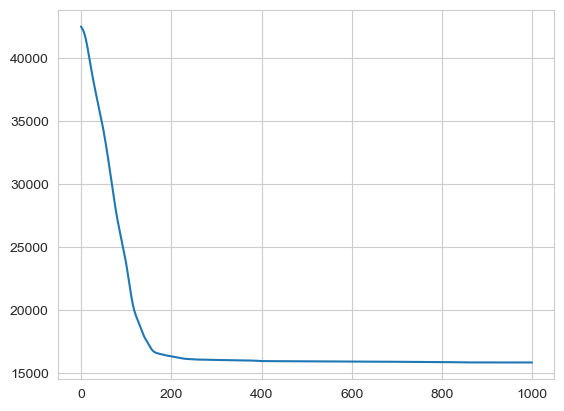

In [23]:
import matplotlib.pyplot as plt

plt.plot(model.losses)
plt.show()

In [24]:
from archetypes.visualization import heatmap
from archetypes.datasets import sort_by_archetype_similarity

In [25]:
alphas = [a.detach().numpy() for a in model.A]
estimated_archetypes = model.Z.detach().numpy()

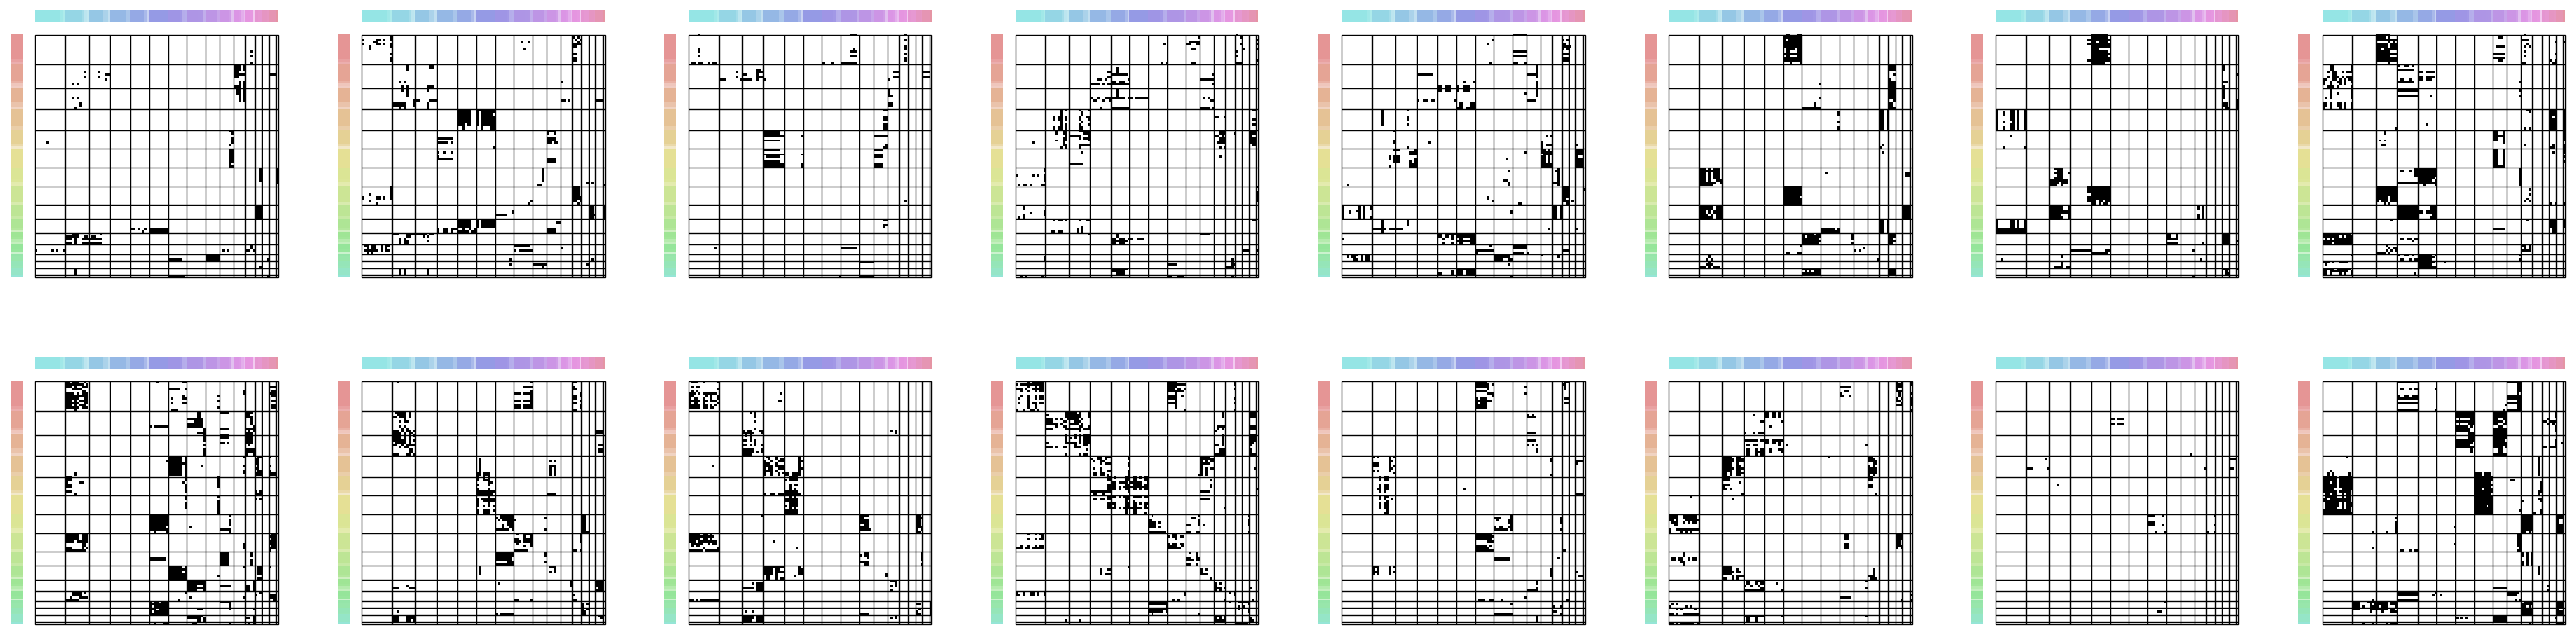

In [26]:

fig, axs = plt.subplots(2, 8, figsize=(40, 10))
for i, ax in enumerate(axs.flatten()):
    data_s, info_s = sort_by_archetype_similarity(data[:, :, i], alphas, estimated_archetypes)
    heatmap(data_s, info_s["labels"], info_s["n_archetypes"], info_s["scores"], ax=ax)


# fig.savefig("figures/irmdata/alyawarra/heatmap.png", dpi=300, bbox_inches='tight')

plt.show()

In [45]:
import pandas as pd

df = pd.DataFrame(mat['features'][:, [3, 4, 8]], columns = ["Gender", "Age", "Kinship"])
group = model.A[1].detach().numpy().argmax(axis=1)
df["group"] = group
# cut age into 6 bins: 0-7, 8-14, 15-29, 30-44, 45-59, 60-99
df["Age"] = pd.cut(df["Age"], bins=[0, 7, 14, 29, 44, 59, 99])
# mutate gender from 0,1 to M,F
df["Gender"][df["Gender"] == 1] = "M"
df["Gender"][df["Gender"] == 2] = "F"

# rename groups to be ordered by kinship
df = df.sort_values(by=["Kinship"])

# rename group number to letter by occurrence order

g_id = df["group"].unique()
# map group id to letter
g_id_map = {g_id[i]: chr(i + 65) for i in range(len(g_id))}
df["group"] = df["group"].map(g_id_map)

df

C:\Users\aalcacer\AppData\Local\Temp\ipykernel_14760\1996534073.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Gender"][df["Gender"] == 1] = "M"
C:\Users\aalcacer\AppData\Local\Temp\ipykernel_14760\1996534073.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Gender"][df["Gender"] == 2] = "F"


,Gender,Age,Kinship,group
0,M,"(59, 99]",1,A
43,M,"(7, 14]",1,B
45,M,"(0, 7]",1,B
49,M,"(14, 29]",1,B
102,F,"(7, 14]",1,C
...,...,...,...,...
32,M,"(14, 29]",4,M
30,M,"(14, 29]",4,M
26,M,"(29, 44]",4,M
3,M,"(59, 99]",4,O


0
1
2


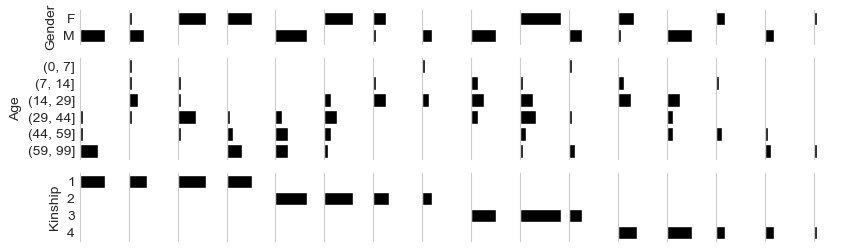

In [46]:
# for each group plot a histogram for each feature
import seaborn as sns

fig, axs = plt.subplots(3, n_arch, figsize=(10, 3), gridspec_kw={'height_ratios': [2, 6, 4]})

for j, col in enumerate(df.columns[:-1]):
    print(j)
    count_max = df.groupby("group")[col].count().max()
    if col == "Kinship":
        order = [1, 2, 3, 4]
    else:
        order = df[col].unique()

    # sort order
    if col == "Age":
        order = sorted(order, key=lambda x: x.left)
    else:
        order = sorted(order)

    for i, ax in enumerate(axs[j]):
        df_i = df[df.group == chr(i + 65)]
        sns.countplot(y=df_i[col], ax=ax, order=order, color="black")
    
        # hide x labels
        ax.set_xticklabels([])
        ax.set_xlabel("")
        if i != 0:
            ax.set_ylabel("")
            ax.set_yticklabels([])
        
        # set x limits
        ax.set_xlim(0, count_max)
        
        # remove axis except y line
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        
        # remove grid lines
        ax.grid(False)
        
        # remove ticks
        ax.tick_params(axis='both', which='both', length=0)

fig.savefig("figures/irmdata/alyawarra/histograms.png", dpi=300, bbox_inches='tight')

plt.show()


Adjusted Rand Index between the estimated groups and the baseline groups

In [47]:
# add an age column if >44 or not

df2 = df.copy()

df2["Age2"] = df2["Age"].apply(lambda x: 0 if x.right > 44 else 1)

df2["Gender2"] = df2["Gender"].apply(lambda x: 0 if x == "M" else 1)

# combine Age2, Gender2 and Kindship into a single column as a tuple

df2["group2"] = df2[["Age2", "Gender2", "Kinship"]].apply(tuple, axis=1)

# mutate group2 to numbers from 0 to 16
df2["group2"] = df2["group2"].astype('category').cat.codes

df2["group"] = df2["group"].astype('category').cat.codes

In [48]:
from sklearn.metrics import adjusted_rand_score

adjusted_rand_score(df2["group"], df2["group2"])


0.6705306198350856